In [1]:
# -----------------------------------------------------------
# IMPORT ALL NECESSARY MODULES
# -----------------------------------------------------------

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import gc
from keras.utils.vis_utils import plot_model
from keras.applications.vgg19 import VGG19
from tqdm import tqdm
from PIL import Image
from IPython.display import display, Image
import tensorflow as tf
import pandas as pd
import numpy as np
%matplotlib inline


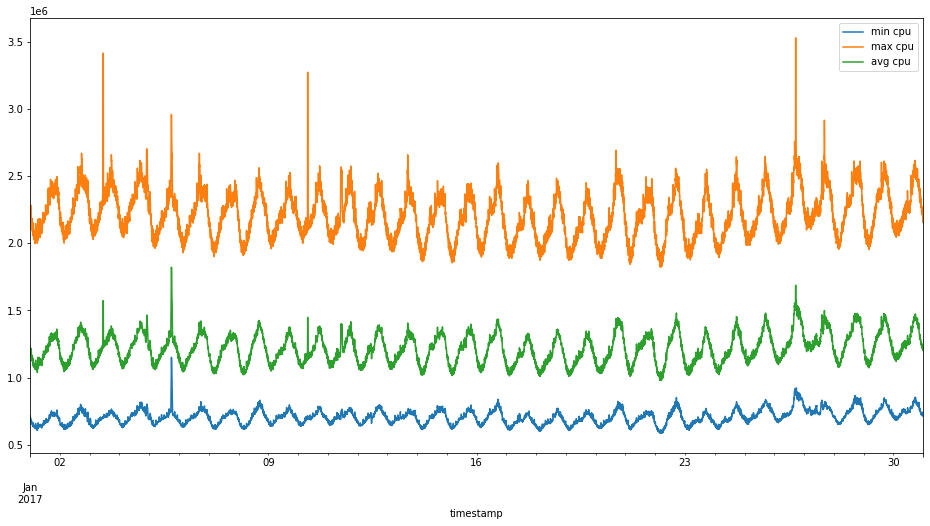

In [2]:
# -----------------------------------------------------------
# LOAD THE DATASET AND PLOT THE OBSERVATIONS
# -----------------------------------------------------------

df = pd.read_csv('azure.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')
df.head()
df.plot(figsize=(16, 8))
plt.show()


In [3]:
# -----------------------------------------------------------
# CREATE TRAIN-TEST SPLIT (80:20)
# -----------------------------------------------------------
TRAIN_LENGTH = round(len(df)*0.8)
TEST_LENGTH = len(df) - TRAIN_LENGTH
train = df.iloc[0:TRAIN_LENGTH]
test = df[TRAIN_LENGTH:]


In [4]:
# -----------------------------------------------------------
# SCALING VALUES
# -----------------------------------------------------------
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=df.columns)
test_scaled = pd.DataFrame(scaler.transform(test), columns=df.columns)


In [5]:
# -----------------------------------------------------------
# GENERATOR TO DATA TO FEED INTO MODEL
# -----------------------------------------------------------
def train_generator(dataset, n_lags=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - n_lags - 1):
        a = dataset.iloc[i:(i+n_lags)].to_numpy()
        dataX.append(a)
        dataY.append(dataset.iloc[i + n_lags].to_numpy())
    return (np.array(dataX), np.array(dataY))


In [6]:
#-----------------------------------------------------------
# DEFINING INPUTS AND EXPECTED OBSERVATIONS
#-----------------------------------------------------------
TIME_STEPS = 500
X_train, y_train = train_generator(train_scaled, n_lags = TIME_STEPS)
X_test_scaled, y_test_scaled = train_generator(test_scaled, n_lags = TIME_STEPS)
X_test, y_test = train_generator(test, n_lags = TIME_STEPS)

In [7]:
# -----------------------------------------------------------
# USING A LSTM MODEL FOR PREDICTION ON TIME SERIES
# -----------------------------------------------------------
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(512, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(tf.keras.layers.LSTM(512, return_sequences=False))
model.add(tf.keras.layers.Dense(3))
model.summary()


2022-08-01 18:15:22.004147: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-01 18:15:22.004257: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 500, 512)          1056768   
                                                                 
 lstm_1 (LSTM)               (None, 512)               2099200   
                                                                 
 dense (Dense)               (None, 3)                 1539      
                                                                 
Total params: 3,157,507
Trainable params: 3,157,507
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(loss='mean_absolute_error', optimizer= tf.keras.optimizers.Adam())

In [9]:
# -----------------------------------------------------------
# DEFINING CALLBACKS
# -----------------------------------------------------------
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
lr_red = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=4, verbose=1, min_lr=0.0000001,)


In [10]:
callbacks = [es, lr_red]
history = model.fit(X_train, y_train,
                    epochs=10,
                    validation_split=0.25,
                    batch_size=256,
                    verbose=1,
                    shuffle=False,
                    callbacks=callbacks)

# -----------------------------------------------------------
# I TRAINED MY MODEL ON BATCHSIZES - 64,128,256
# -----------------------------------------------------------


Epoch 1/10


2022-08-01 18:15:22.616022: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-01 18:15:23.662699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-01 18:15:23.947168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-01 18:15:25.179643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-01 18:15:26.536556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-01 18:15:30.053559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - ETA: 0s - loss: 0.0856

2022-08-01 18:16:27.366873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-01 18:16:27.473043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-01 18:16:28.629086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 71s 3s/step - loss: 0.0856 - val_loss: 0.0571 - lr: 0.0010
Epoch 2/10
19/19 [==============================] - 51s 3s/step - loss: 0.0329 - val_loss: 0.0264 - lr: 0.0010
Epoch 3/10
19/19 [==============================] - 52s 3s/step - loss: 0.0263 - val_loss: 0.0209 - lr: 0.0010
Epoch 4/10
19/19 [==============================] - 51s 3s/step - loss: 0.0228 - val_loss: 0.0214 - lr: 0.0010
Epoch 5/10
19/19 [==============================] - 51s 3s/step - loss: 0.0225 - val_loss: 0.0209 - lr: 0.0010
Epoch 6/10
19/19 [==============================] - 47s 2s/step - loss: 0.0220 - val_loss: 0.0206 - lr: 0.0010
Epoch 7/10
19/19 [==============================] - 52s 3s/step - loss: 0.0217 - val_loss: 0.0200 - lr: 0.0010
Epoch 8/10
19/19 [==============================] - 51s 3s/step - loss: 0.0216 - val_loss: 0.0202 - lr: 0.0010
Epoch 9/10
19/19 [==============================] - 51s 3s/step - loss: 0.0215 - val_loss: 0.0206 - lr: 0.0010
Epoch 10/10


2022-08-01 18:24:10.439633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-01 18:24:10.543038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-01 18:24:11.614539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 10s 200ms/step


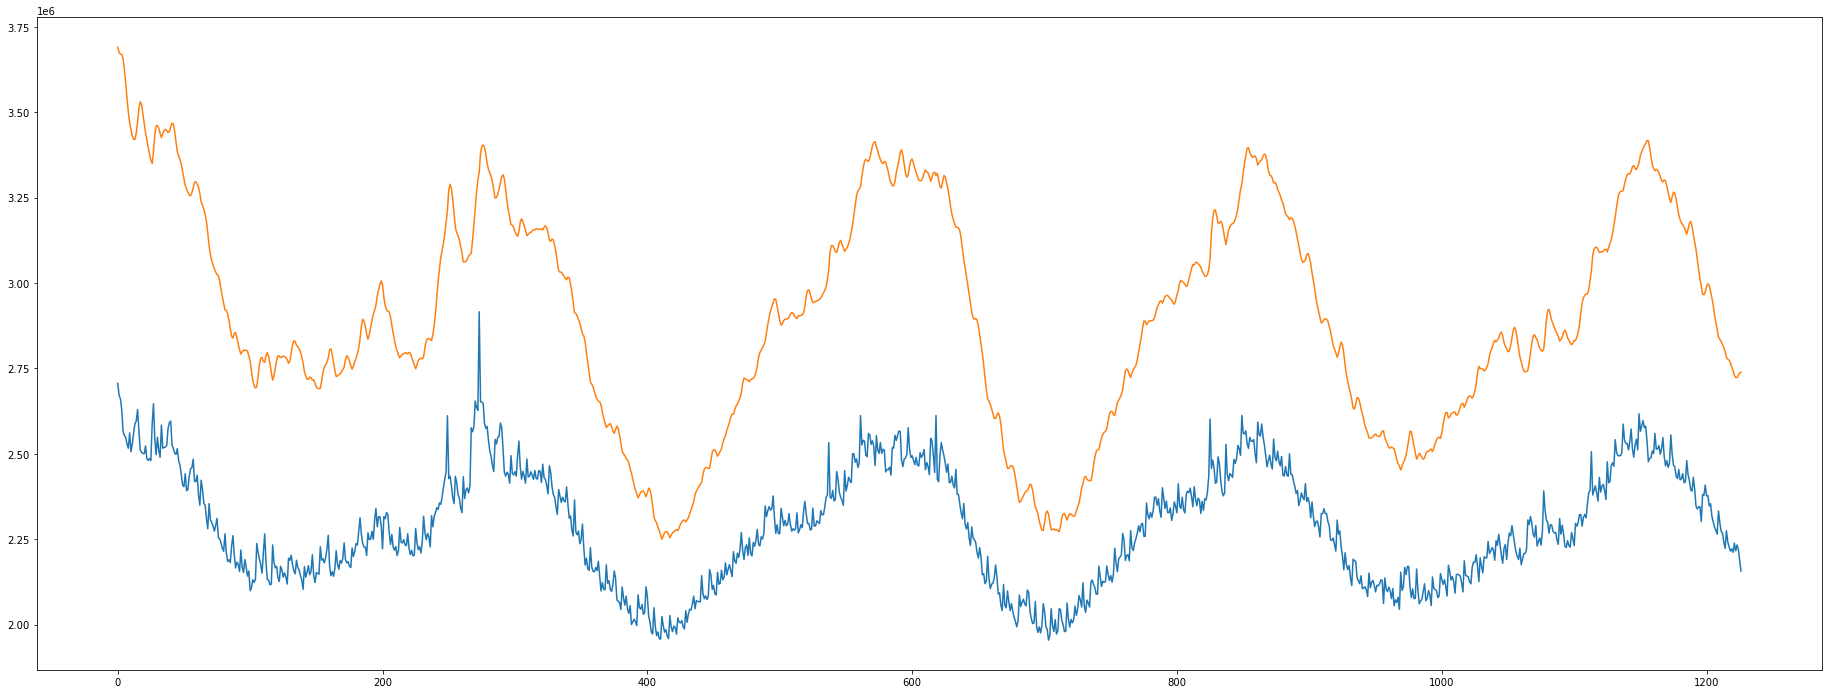

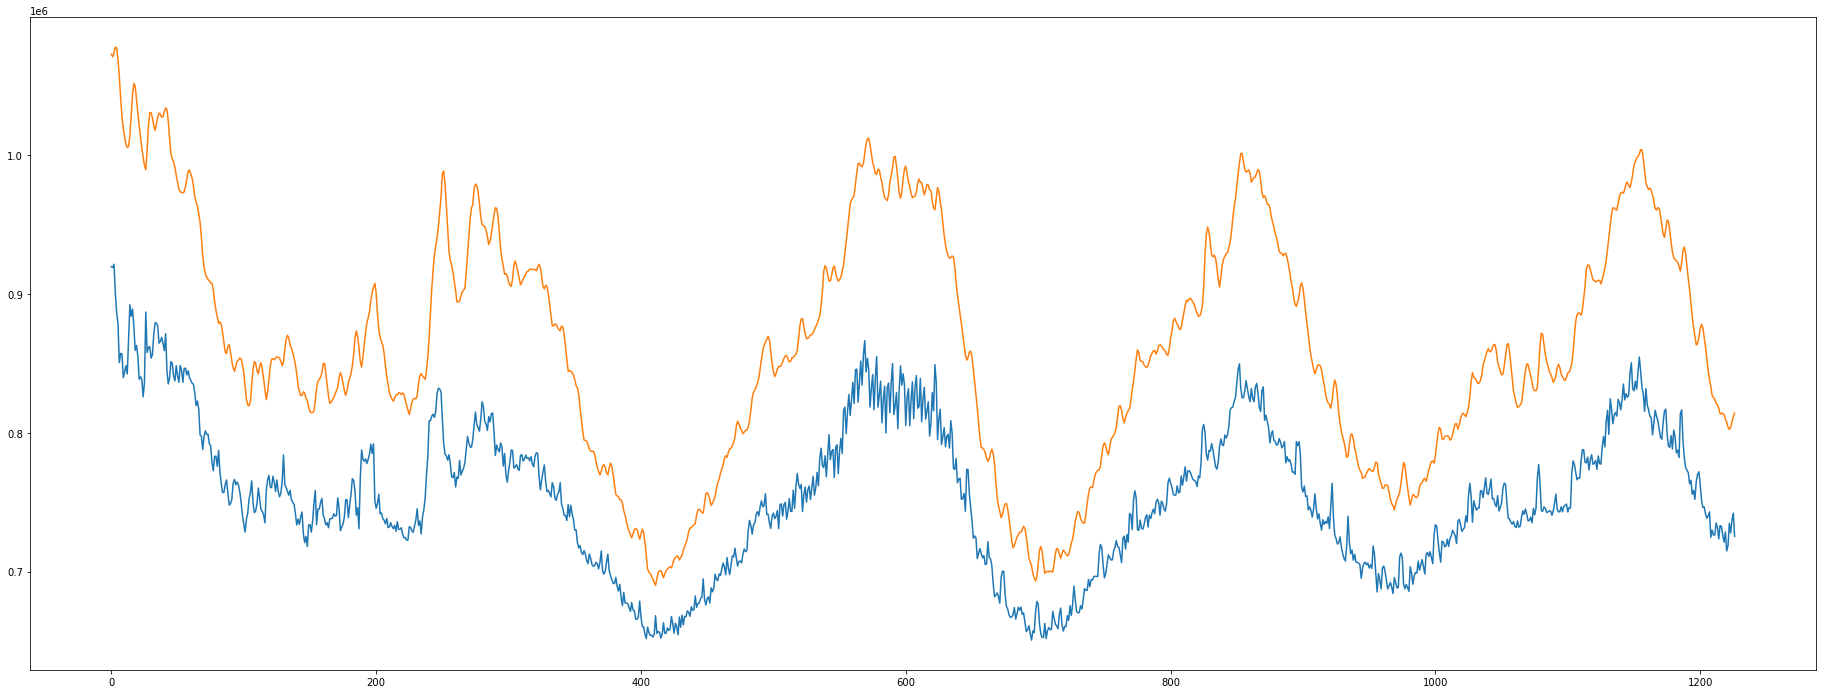

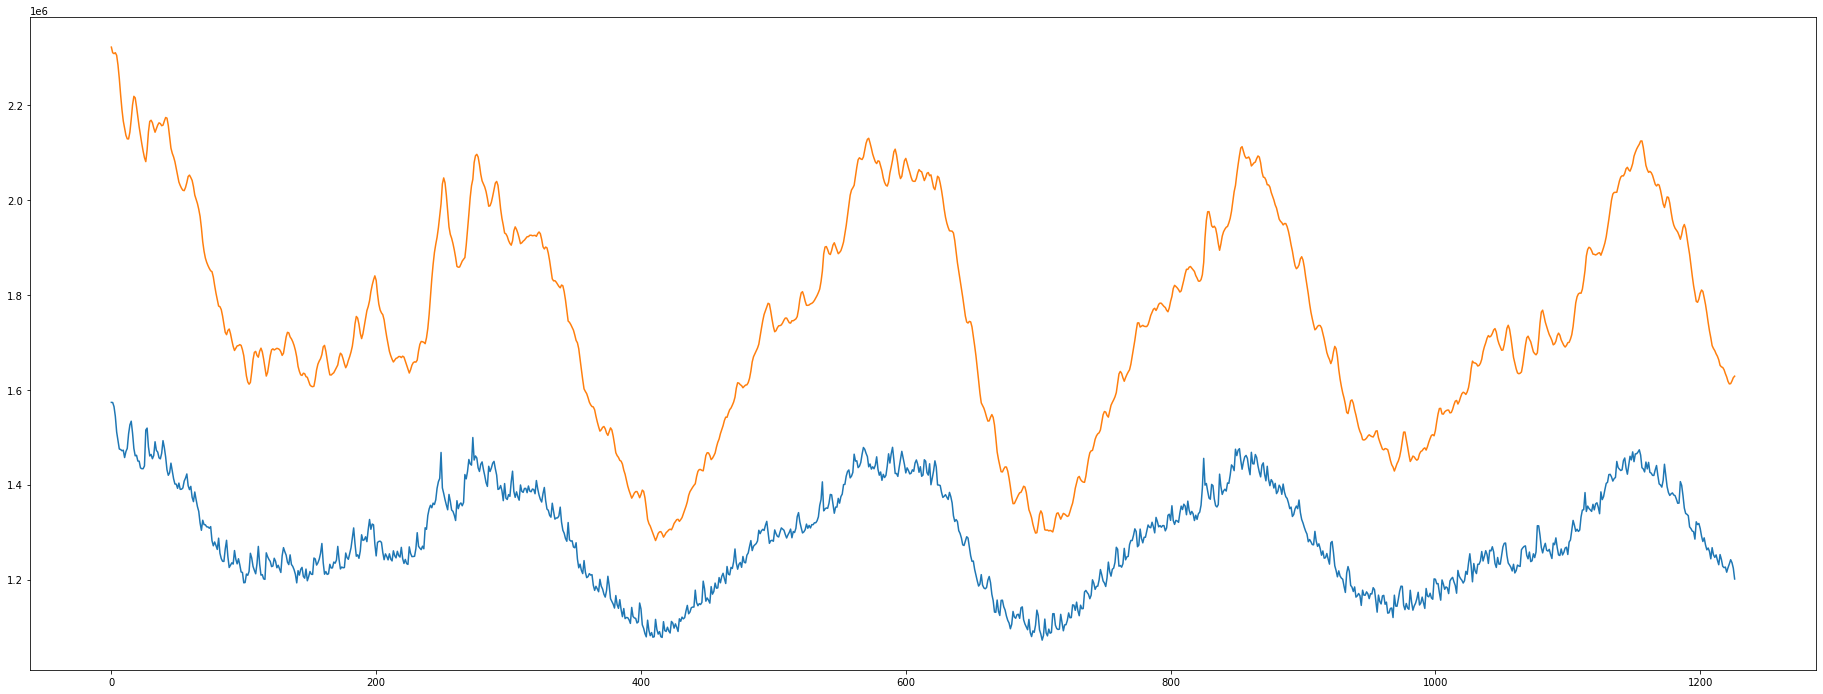

In [11]:
# -----------------------------------------------------------
# MAKING PREDICTIONS ON TEST DATA AND PLOTTING PREDICTED AND
# OBSERVED VALUES
# -----------------------------------------------------------
preds = model.predict(X_test_scaled)
preds = scaler.inverse_transform(preds)

columns: list = ['min_cpu', 'max_cpu', 'avg_cpu']
plt.rcParams["figure.figsize"] = (32, 12)
TestY = pd.DataFrame(y_test, columns=columns)
PredY = pd.DataFrame(preds, columns=columns)


plot_max = plt.figure(1)
plt.plot(TestY['max_cpu'])
plt.plot(PredY['max_cpu'])
plt.show()

plot_min = plt.figure(2)
plt.plot(TestY['min_cpu'])
plt.plot(PredY['min_cpu'])
plt.show()

plot_avg = plt.figure(3)
plt.plot(TestY['avg_cpu'])
plt.plot(PredY['avg_cpu'])
plt.show()


In [12]:
# -----------------------------------------------------------
# LETS CHECK HOW GOOD THE MODEL PERFORMED
# -----------------------------------------------------------
testScore_1 = math.sqrt(mean_squared_error(y_test[:], preds[:]))
print('Test Score: %.2f RMSE' % (testScore_1))

testScore_2 = math.sqrt(mean_absolute_error(y_test[:], preds[:]))
print('Test Score: %f MAE' % (testScore_2))

testScore_3 = np.mean(np.abs(preds - y_test)/np.abs(y_test)*100)
print(f'Test Score: {testScore_3} MAPE')


Test Score: 463551.73 RMSE
Test Score: 627.295975 MAE
Test Score: 25.23570388722449 MAPE
